In [8]:
from tests.helpers import random_orientation, random_position
from imusim.maths.quaternions import QuaternionArray, Quaternion
from imusim.testing.random_data import RandomTrajectory
from imusim.trajectories.sampled import SampledTrajectory
from imusim.trajectories.splined import SplinedTrajectory
from imusim.utilities.time_series import TimeSeries
import functools
import time
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib.gridspec import GridSpec
from crisp.camera import AtanCameraModel
from rsimusim.camera import PinholeModel
from rsimusim.misc import CalibratedGyroStream
from rsimusim.dataset import Dataset
%matplotlib inline

In [2]:
def cost_function_base(t0, landmark, trajectory, camera_model, row, method='abs'):
    row_delta = camera_model.readout / float(camera_model.rows)
    row_time = t0 + row * row_delta
    R = np.array(trajectory.rotation(row_time).toMatrix())
    p = trajectory.position(row_time)
    T = np.hstack((R.T, np.dot(R.T, -p)))
    Xh = np.ones((4,1))
    Xh[:3] = landmark
    landmark_camera = np.dot(T, Xh)
    x, y = camera_model.project(landmark_camera).ravel()
    residual = row - y
    if method == 'abs':
        return np.abs(residual)
    elif method == 'linear':
        return residual
    else:
        raise ValueError('No such method {}'.format(method))

In [3]:
focal = 550.
image_size = (1920, 1080)
K = np.array([[focal, 0, image_size[0]/2.],
             [0, focal, image_size[1]/2.],
             [0, 0, 1]])
fps = 30.
readout = 0.95 / fps
pinhole_camera = PinholeModel(K, image_size, readout, fps)

In [4]:
atan_camera = AtanCameraModel.from_hdf('/home/hannes/Code/crisp/hero3_atan.hdf')

## Load dataset from file
Contains trajectory and landmarks

In [5]:
ds = Dataset.from_file('rccar_openmvg.h5')

## Find misbehaving cases
Try to project using the linear model.
Filter out any point that do not agree with truth up to a threshold (less than a row).
Points that do not have a minimum absolute cost close to 0 are not visible *using the current camera model*.

In [7]:
duration = ds.trajectory.endTime - ds.trajectory.startTime
num_frames = int(pinhole_camera.frame_rate * duration)
rows = np.arange(pinhole_camera.rows)
frame_times = ds.trajectory.startTime + np.arange(num_frames) / pinhole_camera.frame_rate
a = int(0.2 * pinhole_camera.rows)
b = int(0.8 * pinhole_camera.rows)
max_lm_for_frame = 3

pbar = IntProgress(min=0, max=len(frame_times)-1)
display(pbar)
problematic = []
for t0 in frame_times:
    lm_for_frame = 0
    landmarks = ds.visible_landmarks(t0 + 0.5*pinhole_camera.readout)
    random.shuffle(landmarks)
    for lm in landmarks:
        X = lm.position.reshape(3,1)
        cost_func = np.vectorize(functools.partial(cost_function_base, t0, X, ds.trajectory, pinhole_camera, method='linear'))
        cost_linear = cost_func(rows)
        cost_abs = np.abs(cost_linear)
        row_minimum = np.argmin(cost_abs)
        if np.min(cost_abs) < 1: # point is visible in this camera
            # SOlve linear two point model
            cost_a = cost_linear[a]
            cost_b = cost_linear[b]
            row_estimate = a - cost_a * (b - a) / (cost_b - cost_a)
            residual = row_estimate - row_minimum
            if np.abs(residual) > 1.0:
                problematic.append((residual, X, t0))
            lm_for_frame += 1
        if lm_for_frame >= max_lm_for_frame:
            break
    pbar.value += 1

print 'Found', len(problematic), 'problematic projections'

Found 689 problematic projections


In [ ]:
pickle.dump()

## Check problematic projections
If we add third cost measurement, will a new linear or quadratic estimator find the correct projection?

In [37]:
def valid_root(roots, camera_model):
    if not len(roots) == 2:
        raise NotImplementedError("Only quadratic roots implemented")
    if np.all(roots < 0) or np.all(roots > camera_model.rows - 1) or (np.all(roots >= 0) and np.all(roots <= camera_model.rows - 1)):
        print 'No valid roots', roots
        return None
    else:
        for r in roots:
            if 0 <= r < camera_model.rows - 1:
                return r
     
         
linear_result = []
quadratic_result = []
pbar = IntProgress(min=0, max=len(problematic)-1)
display(pbar)
for _, X, t0 in problematic:
    # Find original two points
    cost_func = np.vectorize(functools.partial(cost_function_base, t0, X, ds.trajectory, pinhole_camera, method='linear'))
    cost_linear = cost_func(rows)
    cost_a = cost_linear[a]
    cost_b = cost_linear[b]
    final_true = np.argmin(np.abs(cost_linear))
    
    # Create the third based on linear estimate
    c = a - cost_a * (b - a) / (cost_b - cost_a)
    cost_c = cost_func(c)
    
    xdata_linear = [a, b, c]
    ydata_linear = [cost_a, cost_b, cost_c]
    xdata_quadratic = [a, b, c]
    ydata_quadratic = [cost_a, cost_b, cost_c]
    
    for i in range(10):
        # New linear model
        linear_coef = np.polyfit(xdata_linear, ydata_linear, 1)
        new_linear = np.roots(linear_coef)[0]
        new_linear_cost = cost_func(new_linear)
        residual = new_linear - final_true
        if np.abs(residual) < 1.0:
            linear_result.append((residual, len(xdata_linear)+1))
            break
        else:
            xdata_linear.append(new_linear)
            ydata_linear.append(new_linear_cost)
    else:
        print 'Linear failed to converge'
    
    for i in range(10):
        # New quadratic model
        quadratic_coef = np.polyfit(xdata_quadratic, ydata_quadratic, 2)
        new_quadratic = valid_root(np.roots(quadratic_coef), pinhole_camera)
        new_quadratic_cost = cost_func(new_quadratic)
        residual = new_quadratic - final_true
        if np.abs(residual) < 1.0:
            quadratic_result.append((residual, len(xdata_quadratic)+1))
            break
        else:
            xdata_quadratic.append(new_quadratic)
            ydata_quadratic.append(new_quadratic_cost)
    else:
        print 'Quadratic failed to converge'
    pbar.value += 1
    

Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge
Linear failed to converge


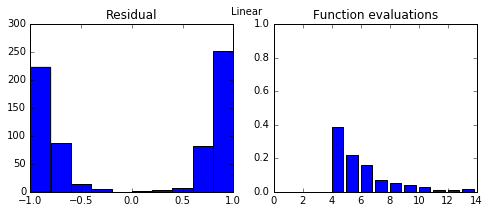

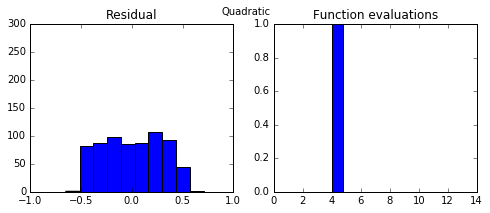

In [38]:
from collections import Counter

for result, name in ((linear_result, 'Linear'), (quadratic_result, 'Quadratic')):
    plt.figure(figsize=(8, 3))
    plt.subplot(1,2,1)
    plt.hist([residual for residual, _ in result])
    plt.title('Residual')
    plt.xlim(-1, 1)
    plt.ylim(0, 300)
    plt.subplot(1,2,2)
    iter_counter = Counter([neval for _, neval in result])
    iterations = sorted(iter_counter.keys())
    iterations_freq = np.array([iter_counter[k] for k in iterations], dtype='float') / len(linear_result)
    plt.bar(iterations, iterations_freq)
    plt.xlim(0, 14)
    plt.ylim(0, 1.0)
    plt.title('Function evaluations')
    plt.suptitle(name)

In [39]:
quadratic_result

[(0.44871660848411921, 4),
 (0.17937212413005454, 4),
 (0.32194393150257383, 4),
 (-0.47526358611719388, 4),
 (0.12823801997853934, 4),
 (0.2440914516189423, 4),
 (-0.28381702458023028, 4),
 (0.01381632882569761, 4),
 (0.017155015739945156, 4),
 (-0.33070049287445613, 4),
 (0.35042077688115114, 4),
 (0.29272847169283978, 4),
 (-0.44999592291378576, 4),
 (0.25934438797570181, 4),
 (0.23718696422463381, 4),
 (0.1063641785647178, 4),
 (-0.34345946577695941, 4),
 (0.18485707585784894, 4),
 (0.39116085154364555, 4),
 (-0.4900062630565003, 4),
 (-0.39464388866826994, 4),
 (-0.231442917496679, 4),
 (-0.45392076746520615, 4),
 (0.10487377177503276, 4),
 (-0.15880256264881609, 4),
 (0.56567499173536362, 4),
 (0.46938372771603554, 4),
 (0.42935466443987025, 4),
 (-0.19740862032335826, 4),
 (0.41601307804319276, 4),
 (0.17921478298333682, 4),
 (-0.5010427873704657, 4),
 (-0.42683839866461426, 4),
 (-0.31229375154930494, 4),
 (0.19868998943536553, 4),
 (0.036197463811447506, 4),
 (0.15639598375588